# Variational AutoEncoder

Task: Implement and train a probabilistic AutoEncoder called Variational AutoEncoder (VAE) on MNIST. A nice introduction to this topic is [here](https://www.jeremyjordan.me/variational-autoencoders/).

In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
cuda = True
device = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 0.001

epochs = 30

In [ ]:
dataset_path = 'datasets'
mnist_transform = torchvision.transforms.Compose([ torchvision.transforms.ToTensor() ]) 
train_dataset = torchvision.datasets.MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



In [ ]:
# Implement Encoder that consists of FC input_dim -> hidden_dim, FC hidden_dim -> hidden_dim, FC hidden_dim -> latent_dim
# You can use LeakyReLU 0.2

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2))
        
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x1 = self.layers(x)
        mean = self.fc_mean(x1)
        log_var = self.fc_log_var(x1)
        return mean, log_var

In [ ]:
# Implement Decoder that consists of FC latent_dim -> hidden_dim, FC hidden_dim -> hidden_dim, FC hidden_dim -> output_dim
# You can use Sigmoid and LeakyReLU 0.2

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, log_var):
        # TODO: implement reparameterization
        sample = mean + torch.exp(0.5*log_var) * torch.randn_like(mean).to(device)
        return sample
                
    def forward(self, x):
        # TODO: implement forward function that uses reparameterization function
        mean, log_var = self.Encoder(x)
        sample = self.reparameterization(mean, log_var)
        return self.Decoder(sample), mean, log_var

    def generate(self, mean, log_var):
        sample = self.reparameterization(mean, log_var)
        return self.Decoder(sample)

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
model = Model(Encoder=encoder, Decoder=decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Loss function for the Gaussian distribution prior is presented in https://arxiv.org/pdf/1907.08956.pdf, Eq. 43.

def loss_function(x, x_hat, mean, log_var):
    rec_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD = -0.5*torch.sum(1 + log_var - torch.exp(log_var) - mean**2)
    return rec_loss + KLD

In [ ]:
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    print("\tEpoch", epoch + 1, "Average Loss: ", overall_loss / (len(train_loader) * batch_size))

	Epoch 1 Average Loss:  173.0643078125
	Epoch 2 Average Loss:  126.56524340820313
	Epoch 3 Average Loss:  116.93318958333333
	Epoch 4 Average Loss:  112.92826598307292
	Epoch 5 Average Loss:  110.16603374023437
	Epoch 6 Average Loss:  108.3685350748698
	Epoch 7 Average Loss:  107.07742552083333
	Epoch 8 Average Loss:  106.09375444335937
	Epoch 9 Average Loss:  105.34872320963542
	Epoch 10 Average Loss:  104.61451409505209
	Epoch 11 Average Loss:  104.17529088541667
	Epoch 12 Average Loss:  103.68780426432292
	Epoch 13 Average Loss:  103.28079298502604
	Epoch 14 Average Loss:  102.94680047200521
	Epoch 15 Average Loss:  102.62257309570313
	Epoch 16 Average Loss:  102.32942885742187
	Epoch 17 Average Loss:  102.10266145833333
	Epoch 18 Average Loss:  101.91276793619792
	Epoch 19 Average Loss:  101.69501513671875
	Epoch 20 Average Loss:  101.47633795572916
	Epoch 21 Average Loss:  101.343693359375
	Epoch 22 Average Loss:  101.21024049479166
	Epoch 23 Average Loss:  101.05483891601563
	Epo

In [ ]:
model.eval()

with torch.no_grad():
    for i, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        x_hat, _, _ = model(x)
        break

In [ ]:
def show_images(x, n_samples=3):
    x = x.view(batch_size, 28, 28) 
    for i in range(n_samples):
      fig = plt.figure()
      plt.imshow(x[i].cpu().numpy())

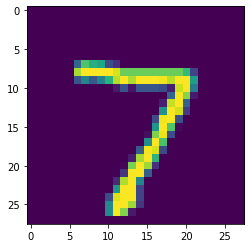

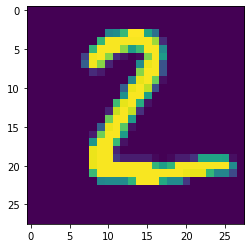

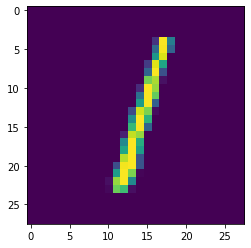

In [ ]:
show_images(x)

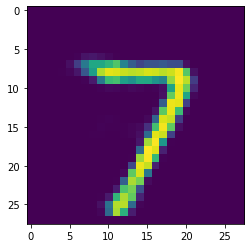

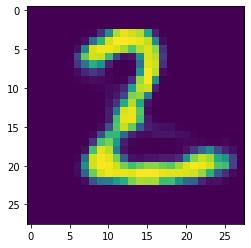

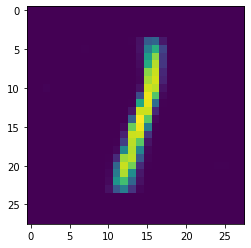

In [ ]:
show_images(x_hat)

In [56]:
# TODO: sample noise, generate new images from noise and show generted images
model.eval()

with torch.no_grad():
    noise_images = torch.randn(batch_size, x_dim).to(device)
    generated_images, _, _ = model(noise_images)

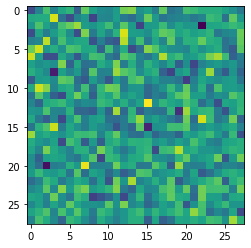

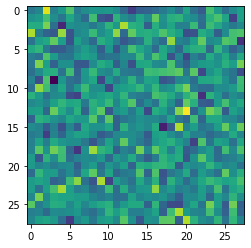

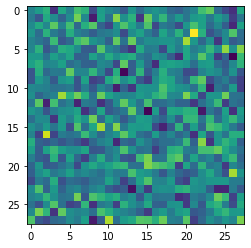

In [57]:
show_images(noise_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


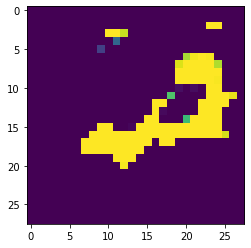

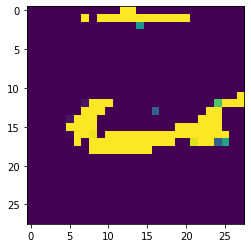

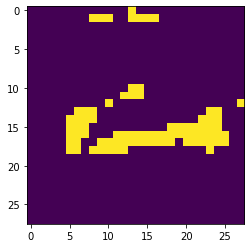

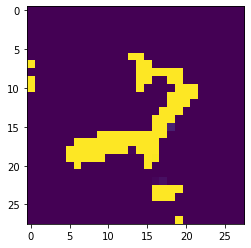

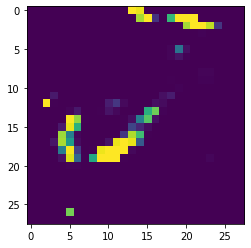

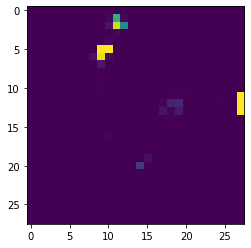

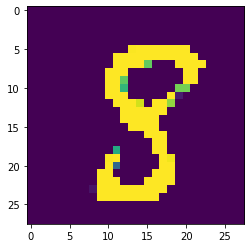

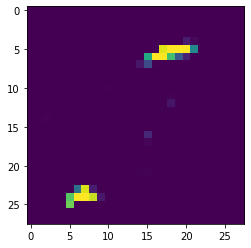

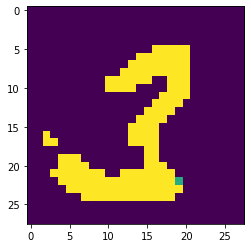

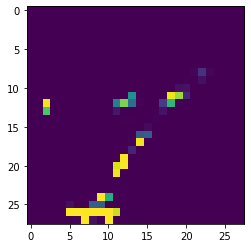

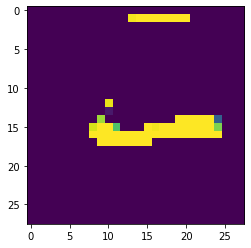

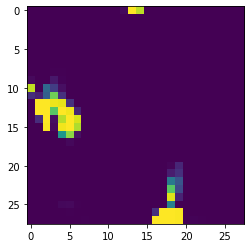

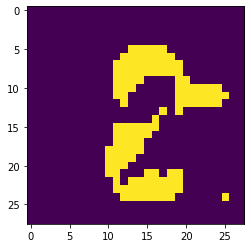

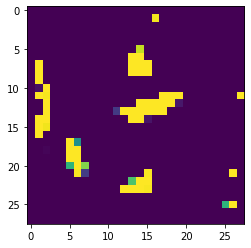

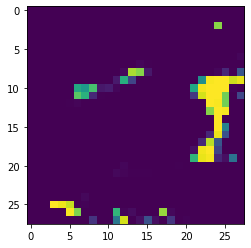

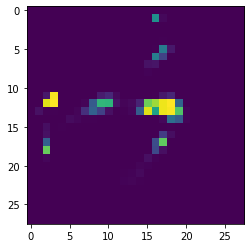

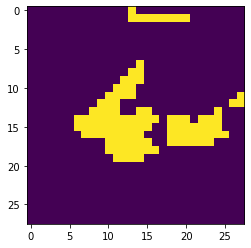

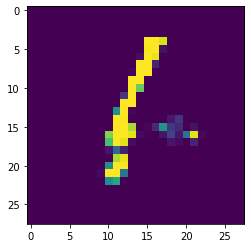

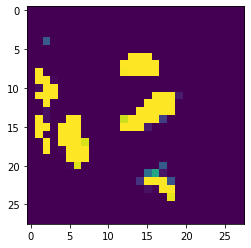

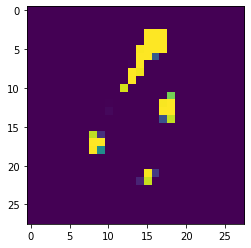

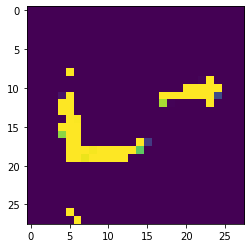

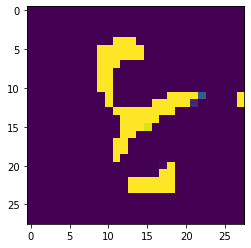

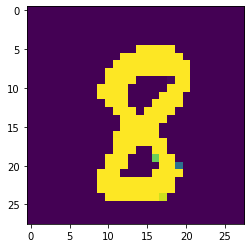

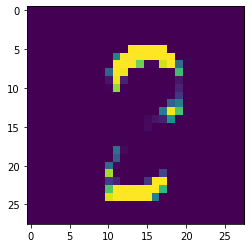

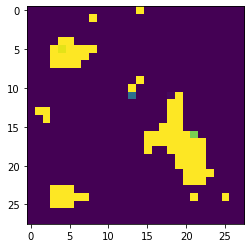

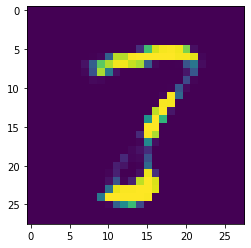

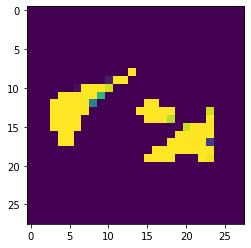

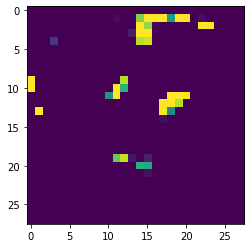

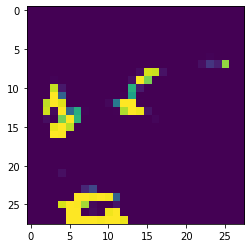

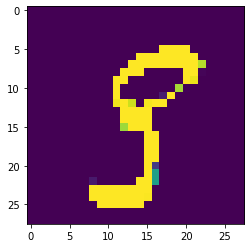

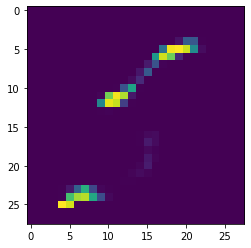

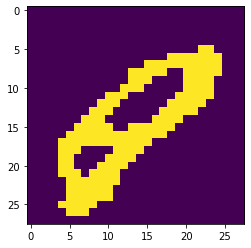

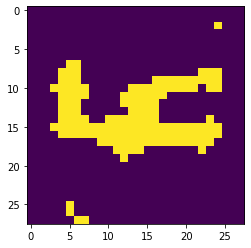

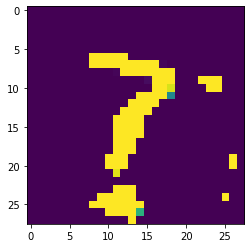

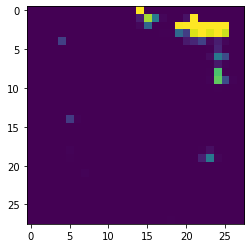

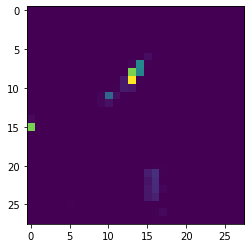

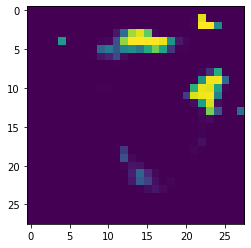

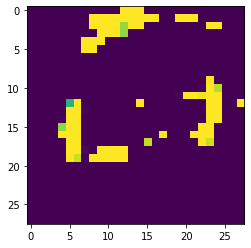

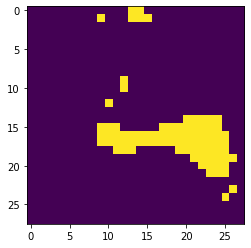

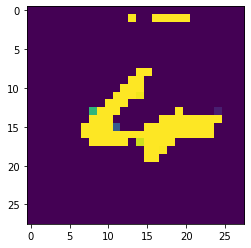

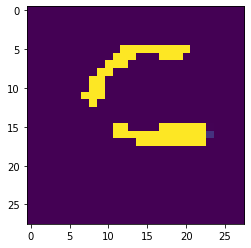

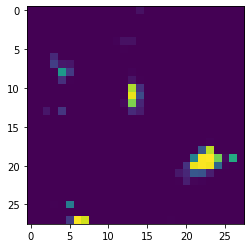

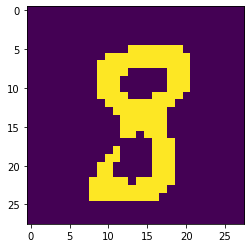

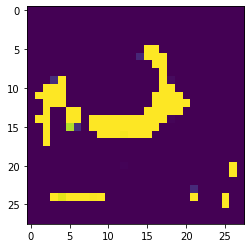

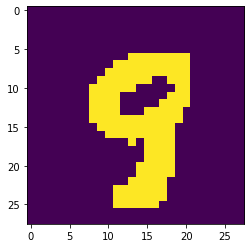

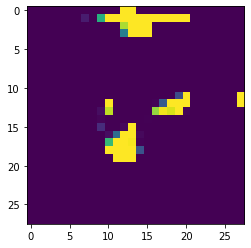

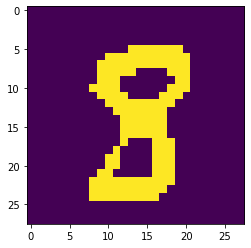

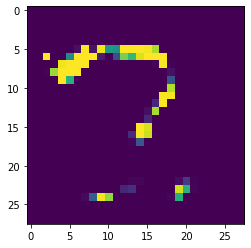

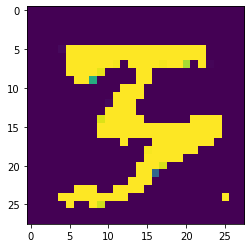

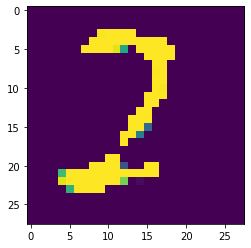

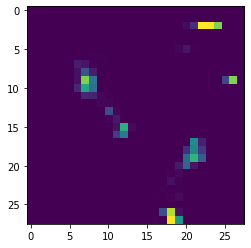

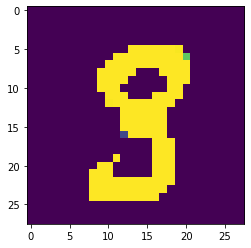

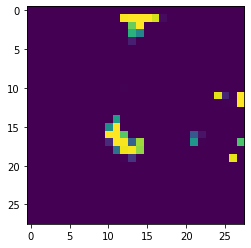

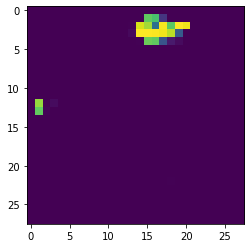

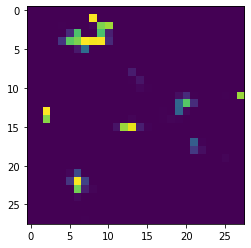

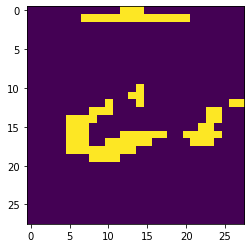

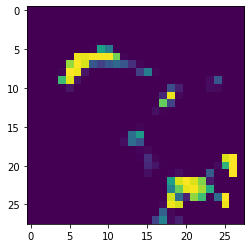

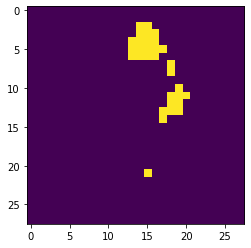

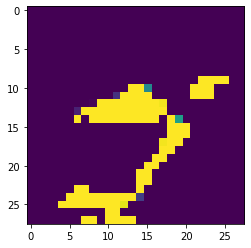

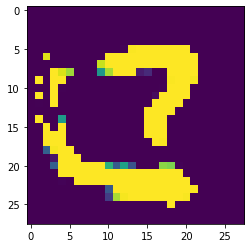

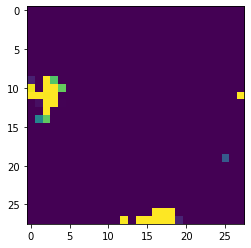

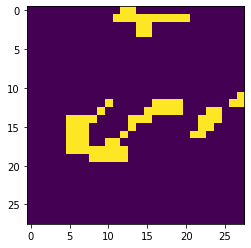

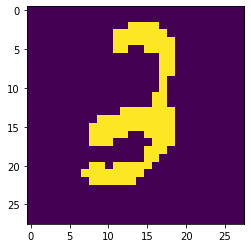

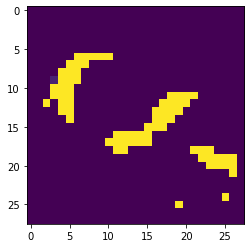

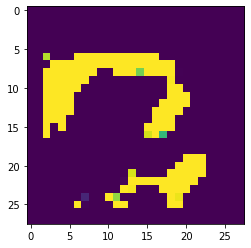

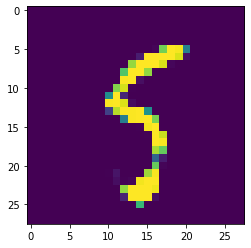

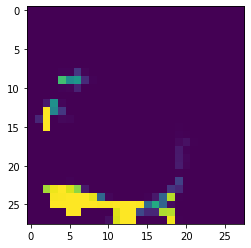

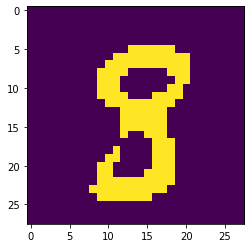

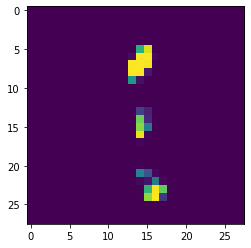

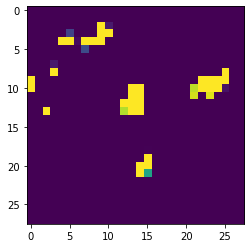

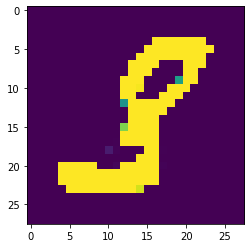

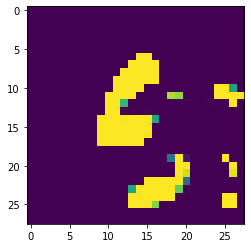

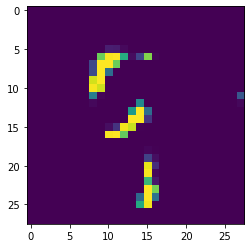

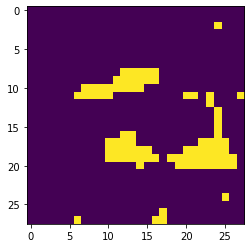

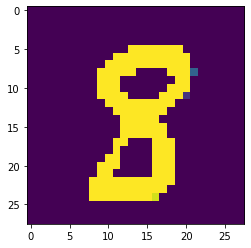

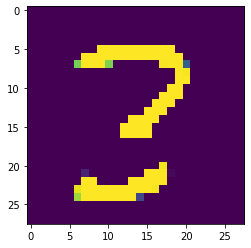

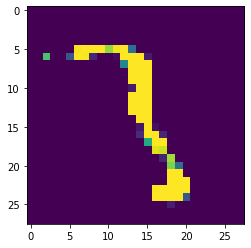

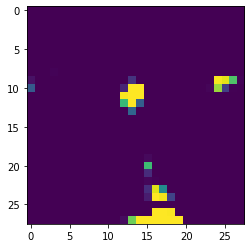

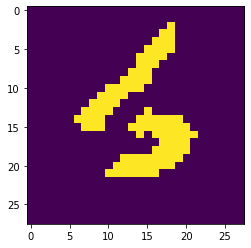

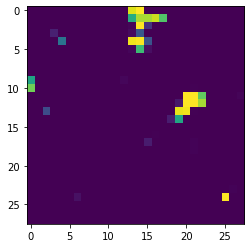

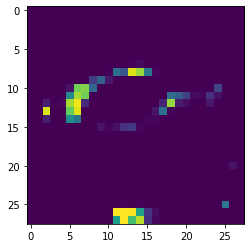

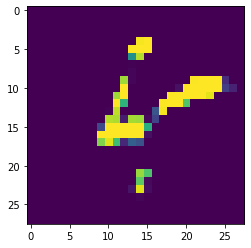

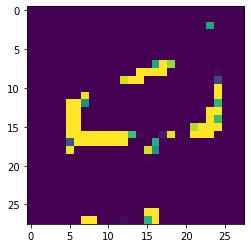

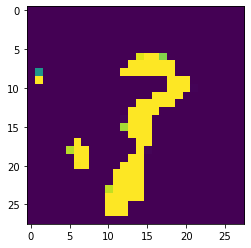

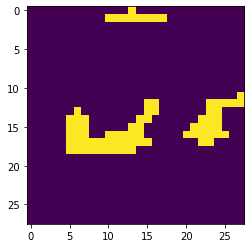

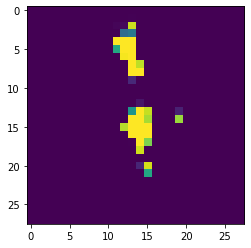

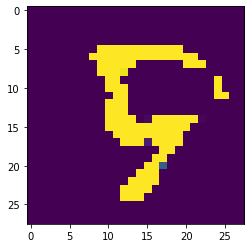

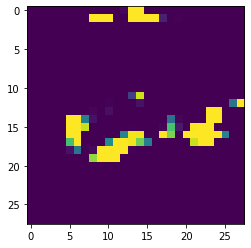

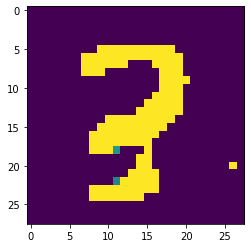

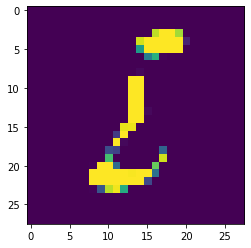

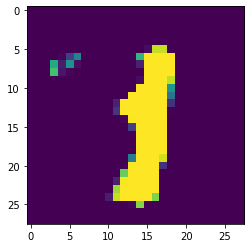

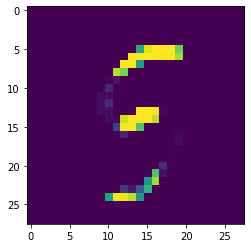

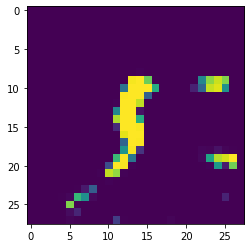

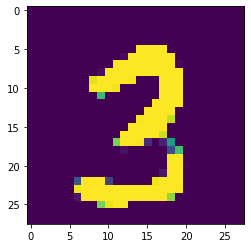

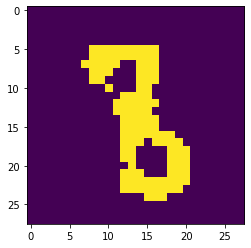

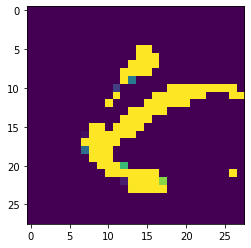

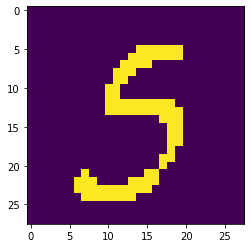

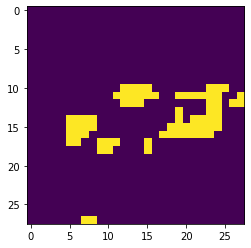

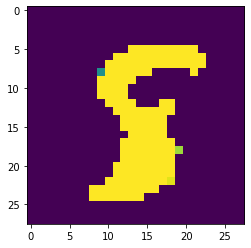

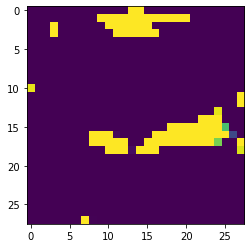

In [58]:
show_images(generated_images, n_samples=100)

In [59]:
def rand_mean(n=100):
    return -3 + 6*torch.rand(n, latent_dim)

def rand_log_var(n=100):
    return -3 + 6*torch.rand(n, latent_dim)

In [60]:
model.eval()

with torch.no_grad():
    mean = rand_mean().to(device)
    log_var = rand_mean().to(device)
    generated_images = model.generate(mean, log_var)

In [61]:
mean[0]

tensor([ 0.7305,  0.5663, -0.2696,  0.4656, -2.2668,  1.0474,  0.4734,  1.7788,
         2.9710, -1.5798,  2.7193,  2.3686, -1.8440, -1.9151,  0.8677,  0.6710,
        -2.6656,  1.5808,  0.5923,  1.2698,  0.9611,  0.3980, -0.0553, -0.1182,
         1.0233, -0.7078, -0.8753, -2.7331, -0.9798,  0.7750,  0.6435, -2.3493,
        -2.4623,  1.4029,  0.5086,  2.6473,  0.7942, -2.3720, -1.0298, -0.9797,
         2.3623,  0.4664, -0.1400,  0.8613, -2.9620,  0.5312,  1.8132,  0.0977,
         1.7500,  1.6176,  0.5932, -1.2652, -2.2971, -0.4746,  0.9485,  1.6022,
         2.2458,  2.3587,  1.3694, -2.7705, -1.2326,  1.0602, -2.0429,  0.1415,
        -1.2845, -0.6661,  0.3411, -1.4180, -0.9851,  0.4541, -2.4971,  1.3551,
         2.3571,  2.5374, -0.4865,  1.3640, -1.7922,  0.2472, -1.4790, -0.5198,
        -1.3214, -2.0437, -2.2138,  0.7332,  1.9974,  0.0048,  1.3169,  1.4057,
        -0.1044,  2.6858,  2.7184,  2.1926, -1.3710,  0.8118,  1.8635, -2.3609,
         1.2841, -0.4917, -2.6699,  1.03

In [62]:
log_var[0]

tensor([-2.1025,  0.5687,  0.0335,  2.6741,  2.0029,  2.0711,  2.8851, -0.2635,
         0.7749,  2.1763,  1.9513, -0.3361,  1.3587, -0.9904,  1.8560, -0.0829,
         2.6963, -1.5241,  2.3957,  0.3086,  2.8953,  0.6683, -0.5077,  2.2966,
        -0.8937, -0.9050,  1.6336, -2.2079, -0.5633,  2.5954,  0.2888, -0.6275,
         0.2056,  1.2622, -0.9945,  2.8736,  0.1698, -0.6919, -2.3654,  1.7376,
        -0.1350, -2.9912, -2.4009,  1.9761, -0.9001, -0.8393,  1.6349, -2.3812,
         0.1825, -1.6152, -1.9655, -1.1633,  1.7773, -1.3036, -0.5013,  1.1440,
         1.8431,  1.2300,  1.4932, -2.0624, -1.3987,  2.3105,  0.3468,  0.1509,
         2.2268,  1.3108,  0.5208,  2.2717, -1.0649, -1.1188, -2.4724,  0.6038,
         2.9400, -0.3135, -1.9804,  1.0673,  2.2278,  0.9824,  2.6998,  2.6726,
         1.9801,  2.1914,  0.0107,  0.6447,  1.4100, -1.1199, -2.8395, -1.1296,
        -0.4078, -2.9394,  1.6330,  1.6902, -1.9527, -1.5110, -2.6979, -1.4561,
        -1.2063,  2.8326,  2.9579, -1.47

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


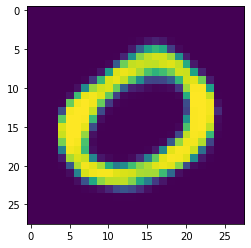

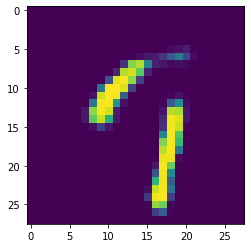

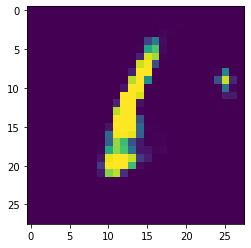

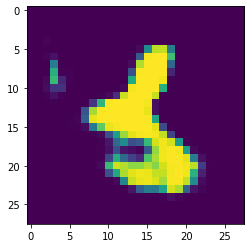

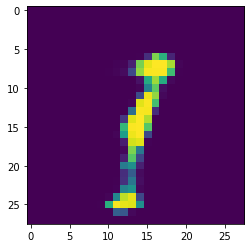

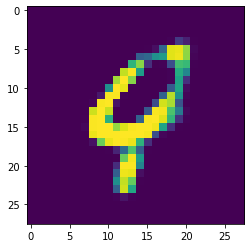

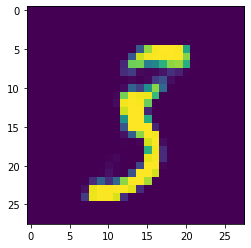

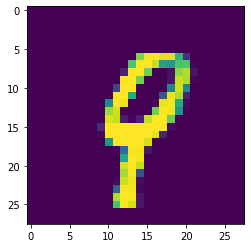

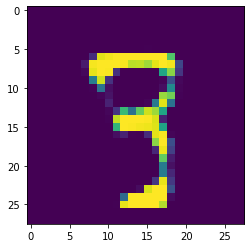

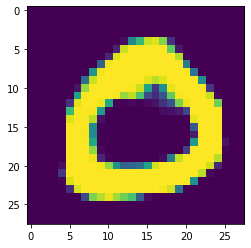

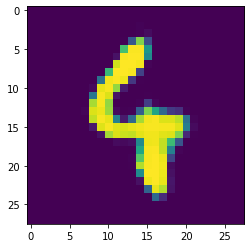

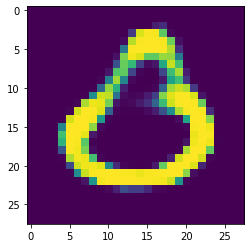

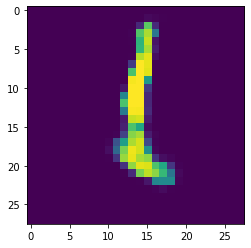

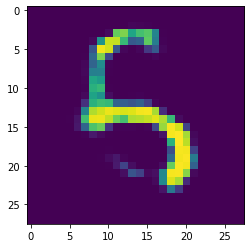

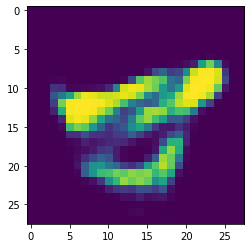

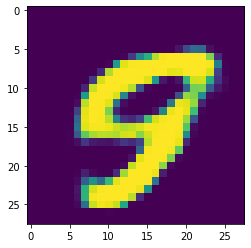

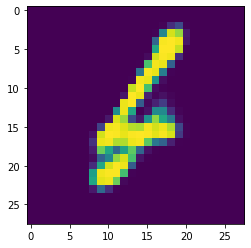

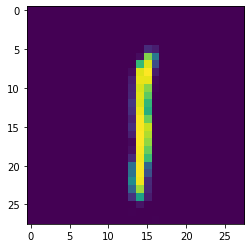

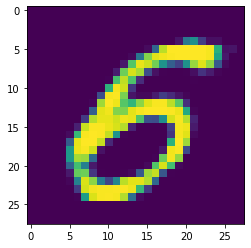

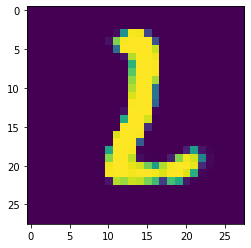

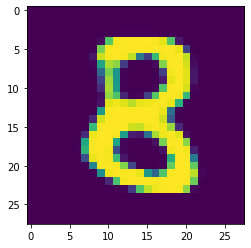

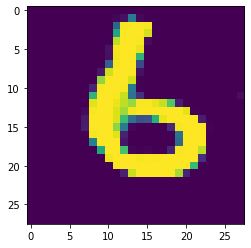

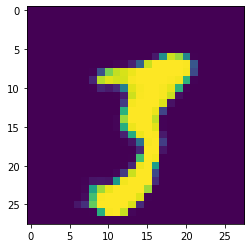

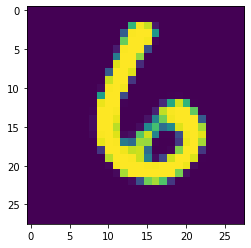

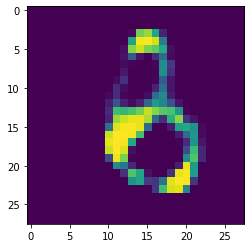

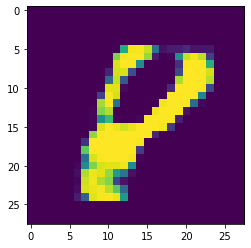

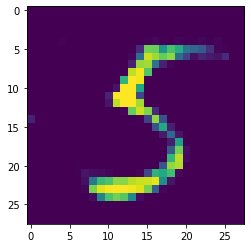

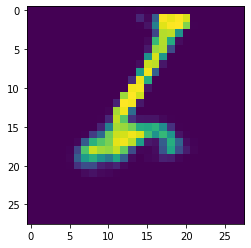

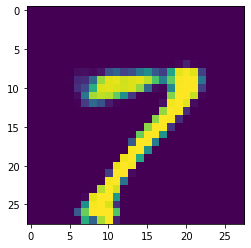

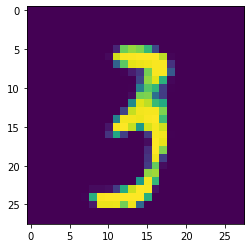

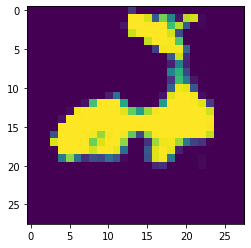

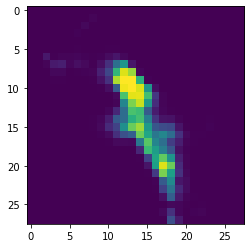

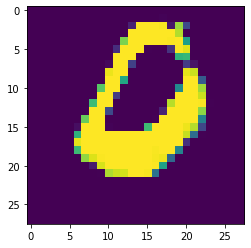

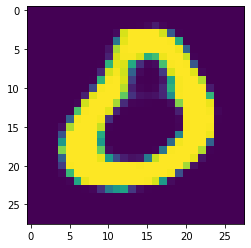

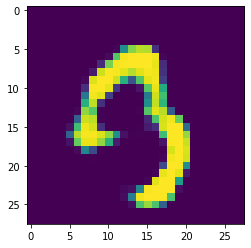

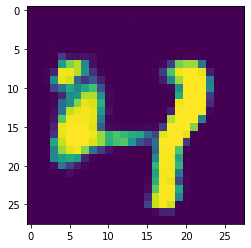

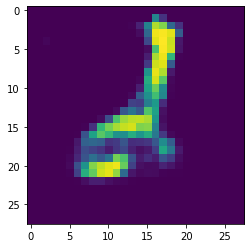

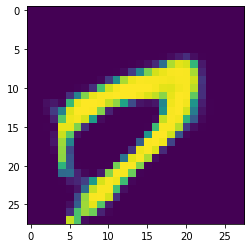

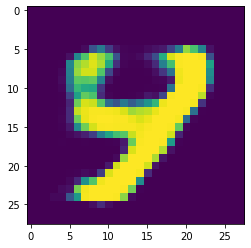

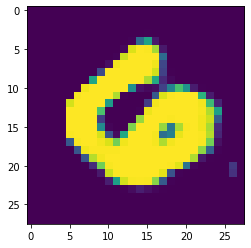

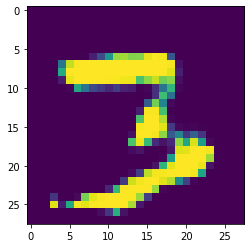

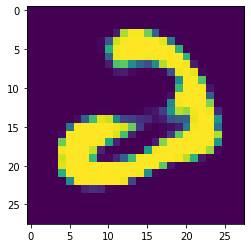

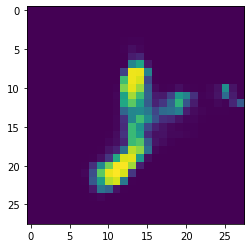

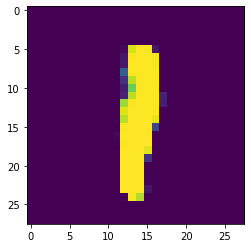

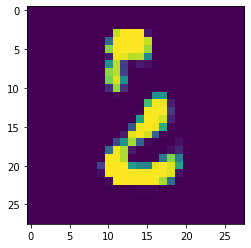

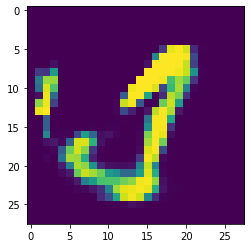

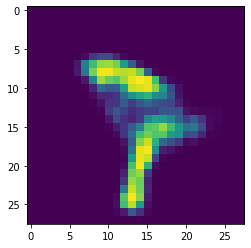

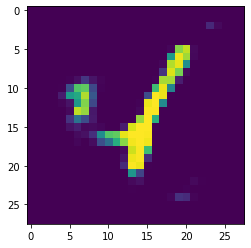

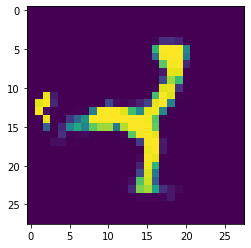

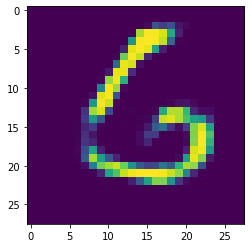

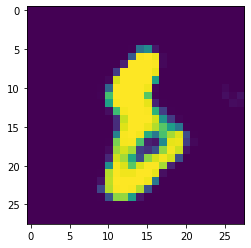

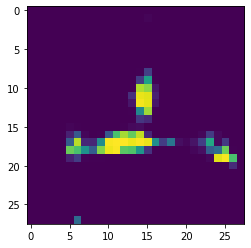

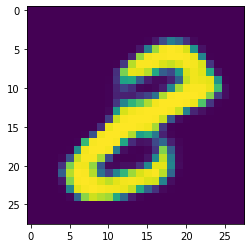

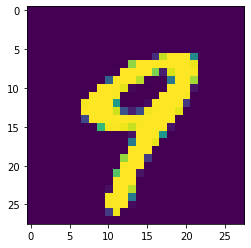

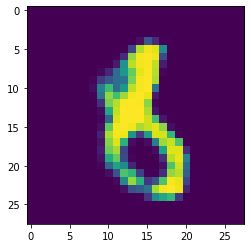

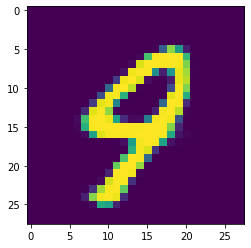

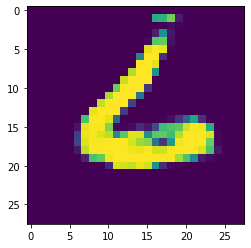

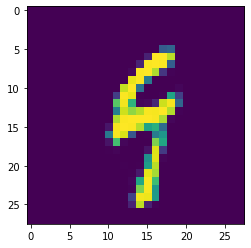

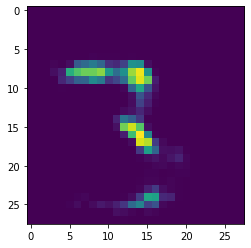

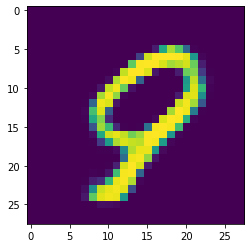

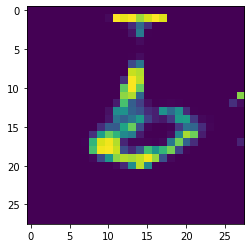

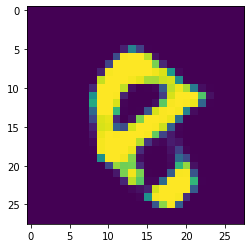

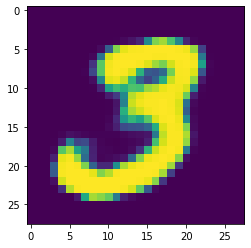

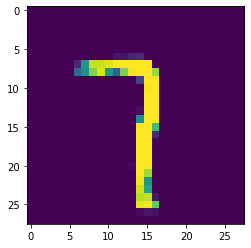

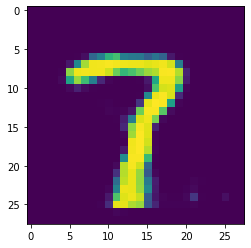

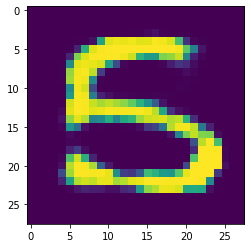

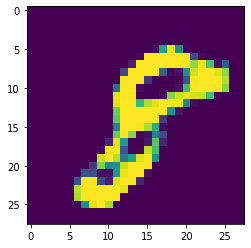

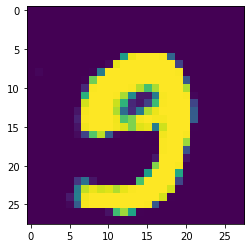

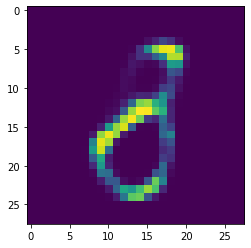

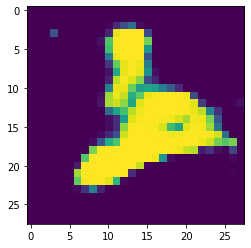

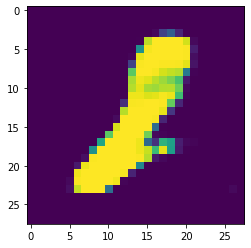

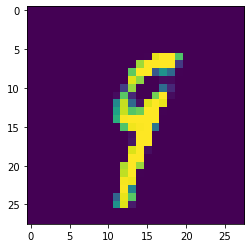

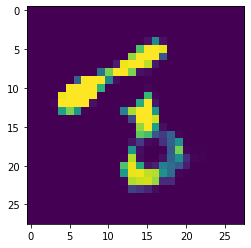

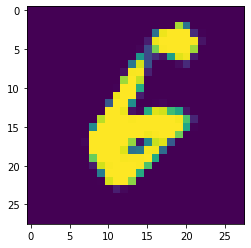

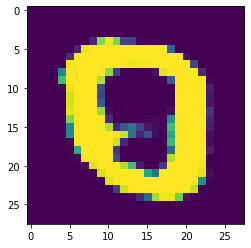

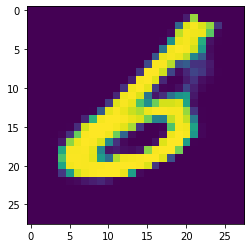

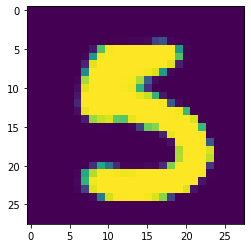

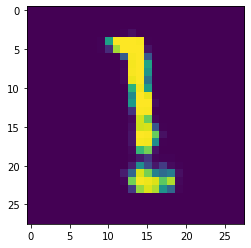

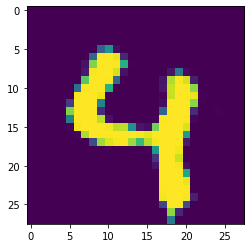

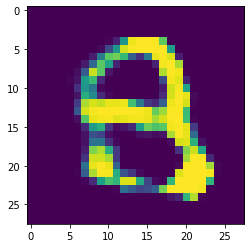

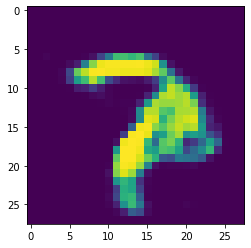

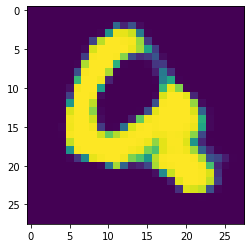

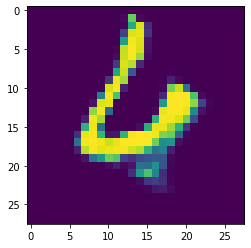

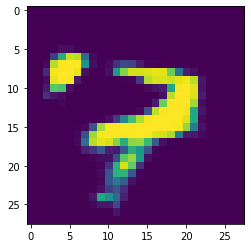

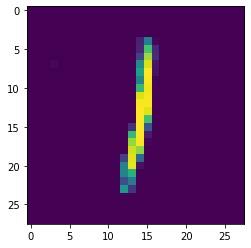

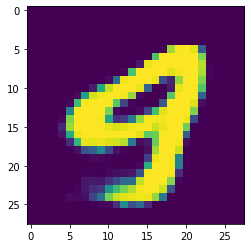

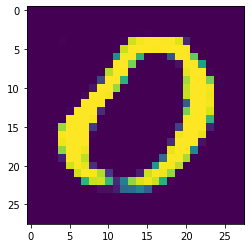

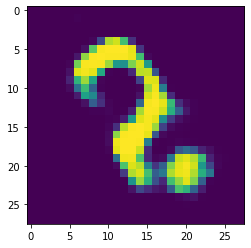

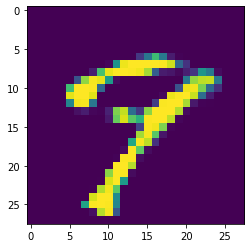

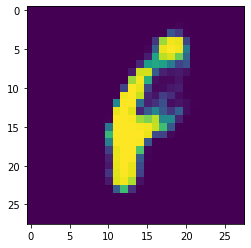

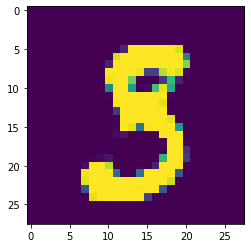

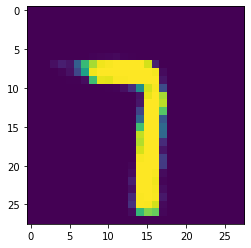

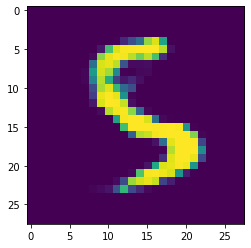

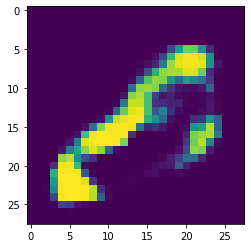

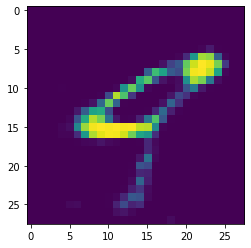

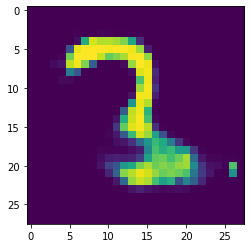

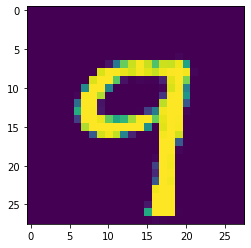

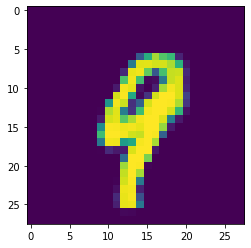

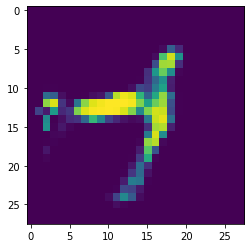

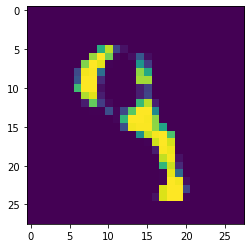

In [63]:
show_images(generated_images, n_samples=100)